# Simple example

SeisCL is of program that performs forward and adjoint seismic modeling for imaging and inversion. In this first example, we show how to use SeisCL to perform basic seismic modeling with the python wrapper. This simple example will solve the 2D isotropic elastic wave equation. 

The first thing to do is to load the SeisCL class and relevant modules:

In [1]:
from SeisCL import SeisCL
import numpy as np
import matplotlib.pyplot as plt
import os

SeisCL is controlled by a single class in python that will group all relevant information to perform forward and adjoint modeling. The class creates all parameters with default values: they can be set at inialization or can be changed later. Note that all the available parameters are defined in the docstring of the `SeisCL` class.

In [2]:
seis = SeisCL()

The class creates all parameters with default values: they can be set at inialization or can be changed later. Note that all the available parameters are defined in the docstring of the SeisCL class, which can be accessed by using the help function:

In [3]:
help(seis.__init__)

Help on method __init__ in module SeisCL.SeisCL:

__init__(N: numpy.ndarray = None, ND: int = 2, dh: float = 10, dt: float = 0.0008, NT: int = 875, L: int = 0, f0: float = 15, FL: numpy.ndarray = array(15), FDORDER: int = 8, MAXRELERROR: int = 1, FP16: int = 0, src_pos_all: numpy.ndarray = array([], shape=(5, 0), dtype=float64), rec_pos_all: numpy.ndarray = array([], shape=(8, 0), dtype=float64), src_all: numpy.ndarray = None, freesurf: int = 0, abs_type: int = 1, VPPML: float = 3500, NPOWER: float = 2, FPML: float = 15, K_MAX_CPML: float = 2, nab: int = 16, abpc: float = 6, with_docker: bool = False, with_mpi: bool = False, NP: int = 1, pref_device_type: int = 4, MPI_NPROC_SHOT: int = 1, nmax_dev: int = 1, no_use_GPUs: numpy.ndarray = array([-1]), gradout: int = 0, Hout: int = 0, gradsrcout: int = 0, back_prop_type: int = 1, cropgrad=True, gradfreqs: numpy.ndarray = array([], shape=(1, 0), dtype=float64), param_type: int = 0, tmax: float = 0, tmin: float = 0, fmin: float = 0, fmax: fl

### Simulation Grid

We begin setting the simulation grid, a 2D square domain of size $\small 500 \times 500 \; m$ with a cell size of $2m$ in all directions. We perform 1000 timesteps with a step size of with  $0.25ms$ for a simulation time of $0.25s$.

In [4]:
seis.ND = 2                                 # Number of dimension
seis.N = np.array([250, 250])               # Grid size [NZ, NX, NY]
seis.dh = dh = 2                            # Grid spatial spacing
seis.dt = dt = 0.25e-03                     # Time step size
seis.NT = NT = 1000                         # Number of time steps

### Velocity Model

For the elastic wave equation, three material parameters are required : $V_p$, $V_s$ and $\rho$. For the sake of simplicity, we the parameters are homegeneous throughout the model, with $V_p = 3500 m/s$, $V_s = 2000 m/s$, $\rho = 2000 kg/m^3$. We store all parameters in a dictionnary, which will be used by the SeisCL class.

In [5]:
vp = 3500
vs = 2000
rho = 2000

vp_a = np.zeros(seis.csts['N']) + vp
vs_a = np.zeros(seis.csts['N']) + vs
rho_a = np.zeros(seis.csts['N']) + rho

model_dict = {"vp": vp_a, "rho": rho_a, "vs": vs_a} 

### Sources and receivers

Source and receivers are totally custumizable by SeisCL: each source can have different receivers, and multiple sources can be fired simultaneously. This flexibilty comes with a price: the definition of the source and receivers becomes verbose pretty easily. 

We provide some utility methods to ease the definition of source and receivers. Here, we use the method `SeisCL.surface_acquisition_2d`, which create a surface acquisition geometry, with receivers and sources at a defined interval of the grid steps along all the model.

In [6]:
seis.surface_acquisition_2d(ds=1000)        

All this function did is to define the attributes `SeisCL.src_pos_all` and `SeisCL.rec_pos_all`.

In [7]:
print(seis.src_pos_all)

[[  36.]
 [   0.]
 [  36.]
 [   0.]
 [ 100.]]


We see here that we have one source, at x=36m, z= 36m (just outside the absorbing boundary), and that the source type is 100 (explosive source). The format of this array is [x, y, z, srcid, src_type], where all shots having the same src_id are fired simultaneously.

In [8]:
print(seis.rec_pos_all[:,0])

[ 40.   0.  36.   0.   1.   0.   0.   0.]


We see here that the first receiver is at x=40m and z=36m. The receiver is for the source id 0, and have the receiver id 1. The receiver id should be unique and start at 1 for the first receiver. The format of this array is [x, y, z, srcid, recid, src_type, none, none, none].


### Simulation

we can now perform the simulation. The method `SeisCL.set_forward` is used to initialize the simulation, i.e. writing the hdf5 files containing simulation parameters and the model. The method  `SeisCL.execute()` launches SeisCL (the compiled program) and wait for the end of execution. 

In [12]:
seis.set_forward([0], model_dict, withgrad=False)
seis.execute()
datafd = seis.read_data()[0]                             

All hdf5 files are created in a temporary directory, called seiscl by default

In [13]:
os.listdir("./seiscl")

['SeisCL_csts.mat', 'SeisCL_model.mat', 'SeisCL_cache', 'SeisCL_dout.mat']

Each file contains specific information required for simulations:
* `SeisCL_csts.mat` contains all simulation parameters (dt, dh, ...)
* `SeisCL_model.mat` contains the material parameter arrays 
* `SeisCL_dout.mat` contains the simulated data.

### Visualization

With matplotlib, we can finally analyze and visualize the result of our simulation.


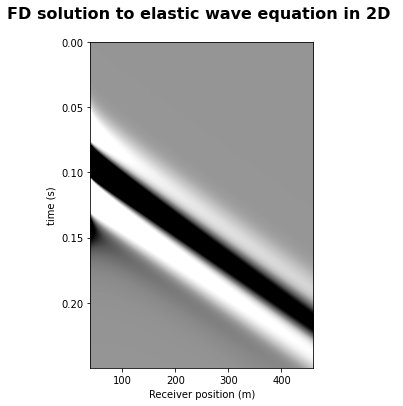

In [14]:
clip = 0.1
extent = [min(seis.rec_pos_all[0]), max(seis.rec_pos_all[0]), (datafd.shape[0]-1)*dt, 0]
vmax = np.max(datafd) * clip
vmin = -vmax
fig, ax = plt.subplots(1, 1, figsize=[4, 6])
ax.imshow(datafd, aspect='auto', vmax=vmax, vmin=vmin, extent = extent,
                interpolation='bilinear', cmap=plt.get_cmap('Greys'))
ax.set_title("FD solution to elastic wave equation in 2D \n", fontsize=16, fontweight='bold')
ax.set_xlabel("Receiver position (m)")
ax.set_ylabel("time (s)")
plt.show()

## Learn more
SeisCL has many more capabilities, including viscoelastic propagation in 2D and 3D, parallelization on multiples devices, adjoint modeling and reverse time migration. You can learn more on these different features with the following notebooks.


 - [Model Building](Model_Building.ipynb)
 
 
 - [Sources & Receivers](Sources&Receivers.ipynb)
 
 
 - [Boundary Conditions](BoundaryLayers.ipynb)
 
 
 - [Free surface](FreeSurface.ipynb)
 
 
 - [Elastic & Viscoelastic modeling](Elastic&Viscoelastic-Modeling.ipynb)
 
 
 - [Analytical comparison](Analytical.ipynb)
 
 
 - [Dictionnary of constants](Dictionnary.ipynb)